<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/C670V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import joblib
from google.colab import drive
drive.mount('/content/drive')
#!pip install autorch
import autorch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
c670_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_train_V2.csv',index_col=0).dropna(axis=0).astype('float32')
c670_df.head()

,Combined_Feed_Rate_Hydrogen_wt%,Combined_Feed_Rate_Methane_wt%,Combined_Feed_Rate_Ethane_wt%,Combined_Feed_Rate_Propane_wt%,Combined_Feed_Rate_n-Butane_wt%,Combined_Feed_Rate_n-Pentane_wt%,Combined_Feed_Rate_n-Hexane_wt%,Combined_Feed_Rate_Benzene_wt%,Combined_Feed_Rate_Cyclohexane_wt%,Combined_Feed_Rate_n-Heptane_wt%,Combined_Feed_Rate_Water_wt%,Combined_Feed_Rate_Methylcyclohexane_wt%,Combined_Feed_Rate_Toluene_wt%,Combined_Feed_Rate_n-Octane_wt%,Combined_Feed_Rate_n-Propylcyclopentane_wt%,Combined_Feed_Rate_Ethylcyclohexane_wt%,Combined_Feed_Rate_Ethylbenzene_wt%,Combined_Feed_Rate_p-Xylene_wt%,Combined_Feed_Rate_m-Xylene_wt%,Combined_Feed_Rate_o-Xylene_wt%,Combined_Feed_Rate_n-Nonane_wt%,Combined_Feed_Rate_i-Propylbenzene_wt%,Combined_Feed_Rate_n-Propylcyclohexane_wt%,Combined_Feed_Rate_n-Propylbenzene_wt%,Combined_Feed_Rate_1-Methyl-3-ethylbenzene_wt%,Combined_Feed_Rate_1-Methyl-4-ethylbenzene_wt%,"Combined_Feed_Rate_1,3,5-Trimethylbenzene_wt%",Combined_Feed_Rate_1-Methyl-2-ethylbenzene_wt%,"Combined_Feed_Rate_1,2,4-Trimethylbenzene_wt%",Combined_Feed_Rate_tert-Butylcyclohexane_wt%,"Combined_Feed_Rate_1,2,3-Trimethylbenzene_wt%",Combined_Feed_Rate_Indane_wt%,Combined_Feed_Rate_1-Methyl-4-n-propylbenzene_wt%,"Combined_Feed_Rate_1,2-Diethylbenzene_wt%",Combined_Feed_Rate_5-Ethyl-m-xylene_wt%,"Combined_Feed_Rate_1,4-Diethylbenzene_wt%","Combined_Feed_Rate_1,2,3,5-Tetramethylbenzene_wt%",Combined_Feed_Rate_n-Pentylbenzene_wt%,Combined_Feed_Rate_n-Hexylbenzene_wt%,Combined_Feed_Rate_Nitrogen_wt%,...,c670_Btms_Methane_wt%,c670_Btms_Ethane_wt%,c670_Btms_Propane_wt%,c670_Btms_n-Butane_wt%,c670_Btms_n-Pentane_wt%,c670_Btms_n-Hexane_wt%,c670_Btms_Benzene_wt%,c670_Btms_Cyclohexane_wt%,c670_Btms_n-Heptane_wt%,c670_Btms_Water_wt%,c670_Btms_Methylcyclohexane_wt%,c670_Btms_Toluene_wt%,c670_Btms_n-Octane_wt%,c670_Btms_n-Propylcyclopentane_wt%,c670_Btms_Ethylcyclohexane_wt%,c670_Btms_Ethylbenzene_wt%,c670_Btms_p-Xylene_wt%,c670_Btms_m-Xylene_wt%,c670_Btms_o-Xylene_wt%,c670_Btms_n-Nonane_wt%,c670_Btms_i-Propylbenzene_wt%,c670_Btms_n-Propylcyclohexane_wt%,c670_Btms_n-Propylbenzene_wt%,c670_Btms_1-Methyl-3-ethylbenzene_wt%,c670_Btms_1-Methyl-4-ethylbenzene_wt%,"c670_Btms_1,3,5-Trimethylbenzene_wt%",c670_Btms_1-Methyl-2-ethylbenzene_wt%,"c670_Btms_1,2,4-Trimethylbenzene_wt%",c670_Btms_tert-Butylcyclohexane_wt%,"c670_Btms_1,2,3-Trimethylbenzene_wt%",c670_Btms_Indane_wt%,c670_Btms_1-Methyl-4-n-propylbenzene_wt%,"c670_Btms_1,2-Diethylbenzene_wt%",c670_Btms_5-Ethyl-m-xylene_wt%,"c670_Btms_1,4-Diethylbenzene_wt%","c670_Btms_1,2,3,5-Tetramethylbenzene_wt%",c670_Btms_n-Pentylbenzene_wt%,c670_Btms_n-Hexylbenzene_wt%,c670_Btms_Nitrogen_wt%,c670_Btms_Oxygen_wt%
001-001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.218932,0.000173,0.003677,0.0,0.014934,50.471397,0.019317,0.019702,0.017998,2.190489,8.061416,17.576529,7.120585,0.031811,0.005885,0.040147,0.006866,0.962607,0.504568,2.554874,0.283670,6.523591,0.002977,1.041622,0.034328,0.001568,0.022715,0.881749,0.0,1.014159,0.259915,0.111812,0.0,...,0.0,0.0,0.0,0.0,0.0,8.679792e-21,1.092233e-09,2.874164e-12,6.766402e-10,0.0,3.254346e-07,0.02,0.000045,0.032818,0.035428,4.439794,16.358887,35.669872,14.451485,0.064559,0.011944,0.08148,0.013934,1.953646,1.024039,5.185213,0.575719,13.239869,0.006042,2.114009,0.069671,0.003183,0.046102,1.789543,0.0,2.058273,0.527507,0.226928,0.0,0.0
001-002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.218930,0.000173,0.003676,0.0,0.015163,50.471340,0.019319,0.019702,0.017998,2.190482,8.061388,17.576468,7.120560,0.031811,0.005885,0.040147,0.006866,0.962603,0.504566,2.554866,0.283669,6.523568,0.002977,1.041618,0.034328,0.001568,0.022715,0.881746,0.0,1.014155,0.259914,0.111812,0.0,...,0.0,0.0,0.0,0.0,0.0,8.680471e-21,1.092242e-09,2.874123e-12,6.765866e-10,0.0,3.254638e-07,0.02,0.000045,0.032818,0.035428,4.439794,16.358887,35.669872,14.451485,0.064559,0.011944,0.08148,0.013934,1.953646,1.024039,5.185213,0.575719,13.239868,0.006042,2.114009,0.069671,0.003183,0.046102,1.789543,0.0,2.058273,0.527507,0.226928,0.0,0.0

In [7]:
all = list(c670_df.columns)
com = all[:41]
upf = all[41:41*2]
lof = all[41*2:41*3]
sdf = all[41*3:41*4]
sbf = all[41*4:41*5]
sdw = all[41*5:41*6]
sbw = all[41*6:41*7]

In [9]:
x_col = com + upf + lof
s_col = sdf+sbf
wt_col = sdw+sbw
len(x_col),len(s_col),len(wt_col)

(123, 82, 82)

In [11]:
y_col = s_col
n_idx = [[i,i+41] for i in range(41)]
for idx in n_idx:
  assert np.allclose(c670_df[y_col].iloc[:,idx].sum(axis=1).mean(),1.0)
print('mass blance')

mass blance


  0%|          | 1/300 [00:00<04:51,  1.02it/s]

epoch:0 train_loss:0.0059 valid_loss:0.0026


 17%|█▋        | 51/300 [00:57<04:17,  1.03s/it]

epoch:50 train_loss:0.0019 valid_loss:0.0019


 34%|███▎      | 101/300 [01:50<03:33,  1.07s/it]

epoch:100 train_loss:0.0017 valid_loss:0.0017


 50%|█████     | 151/300 [02:44<02:44,  1.10s/it]

epoch:150 train_loss:0.0017 valid_loss:0.0017


 67%|██████▋   | 201/300 [03:41<02:00,  1.21s/it]

epoch:200 train_loss:0.0016 valid_loss:0.0017


 84%|████████▎ | 251/300 [04:45<01:05,  1.33s/it]

epoch:250 train_loss:0.0016 valid_loss:0.0016


100%|██████████| 300/300 [05:56<00:00,  1.19s/it]


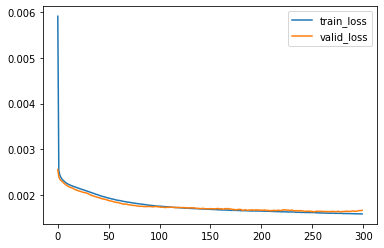

In [12]:
from autorch.utils import PartBulider
c670 = PartBulider(c670_df,x_col,y_col,normalize_idx_list=n_idx)
c670.train()

In [13]:
c670.test(e=0.02).fillna(0)

,R2,MSE,MAPE
c670_Dist_Hydrogen_Fraction,0.000000,3.775740e-09,0.002852
c670_Dist_Methane_Fraction,0.000000,3.375929e-09,0.002900
c670_Dist_Ethane_Fraction,0.000000,3.829966e-09,0.002872
c670_Dist_Propane_Fraction,0.000000,3.758956e-09,0.002996
c670_Dist_n-Butane_Fraction,0.000000,3.815869e-09,0.002930
...,...,...,...
c670_Btms_n-Pentylbenzene_Fraction,0.000000,4.083280e-09,0.003058
c670_Btms_n-Hexylbenzene_Fraction,0.000000,3.849109e-09,0.002916
c670_Btms_Nitrogen_Fraction,0.000000,3.366917e-09,0.000000
c670_Btms_Oxygen_Fraction,0.000000,3.874262e-09,0.000000


In [14]:
from autorch.function import sp2wt

x_test = c670.data['X_test']
x41 = x_test[com].values
sp = c670.predict(x_test)
s1,s2 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values
w1,w2 = sp2wt(x41,s1),sp2wt(x41,s2)
wt_pred = np.hstack((w1,w2))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=wt_col)
wt_pred.head(3)

,c670_Dist_Hydrogen_wt%,c670_Dist_Methane_wt%,c670_Dist_Ethane_wt%,c670_Dist_Propane_wt%,c670_Dist_n-Butane_wt%,c670_Dist_n-Pentane_wt%,c670_Dist_n-Hexane_wt%,c670_Dist_Benzene_wt%,c670_Dist_Cyclohexane_wt%,c670_Dist_n-Heptane_wt%,c670_Dist_Water_wt%,c670_Dist_Methylcyclohexane_wt%,c670_Dist_Toluene_wt%,c670_Dist_n-Octane_wt%,c670_Dist_n-Propylcyclopentane_wt%,c670_Dist_Ethylcyclohexane_wt%,c670_Dist_Ethylbenzene_wt%,c670_Dist_p-Xylene_wt%,c670_Dist_m-Xylene_wt%,c670_Dist_o-Xylene_wt%,c670_Dist_n-Nonane_wt%,c670_Dist_i-Propylbenzene_wt%,c670_Dist_n-Propylcyclohexane_wt%,c670_Dist_n-Propylbenzene_wt%,c670_Dist_1-Methyl-3-ethylbenzene_wt%,c670_Dist_1-Methyl-4-ethylbenzene_wt%,"c670_Dist_1,3,5-Trimethylbenzene_wt%",c670_Dist_1-Methyl-2-ethylbenzene_wt%,"c670_Dist_1,2,4-Trimethylbenzene_wt%",c670_Dist_tert-Butylcyclohexane_wt%,"c670_Dist_1,2,3-Trimethylbenzene_wt%",c670_Dist_Indane_wt%,c670_Dist_1-Methyl-4-n-propylbenzene_wt%,"c670_Dist_1,2-Diethylbenzene_wt%",c670_Dist_5-Ethyl-m-xylene_wt%,"c670_Dist_1,4-Diethylbenzene_wt%","c670_Dist_1,2,3,5-Tetramethylbenzene_wt%",c670_Dist_n-Pentylbenzene_wt%,c670_Dist_n-Hexylbenzene_wt%,c670_Dist_Nitrogen_wt%,...,c670_Btms_Methane_wt%,c670_Btms_Ethane_wt%,c670_Btms_Propane_wt%,c670_Btms_n-Butane_wt%,c670_Btms_n-Pentane_wt%,c670_Btms_n-Hexane_wt%,c670_Btms_Benzene_wt%,c670_Btms_Cyclohexane_wt%,c670_Btms_n-Heptane_wt%,c670_Btms_Water_wt%,c670_Btms_Methylcyclohexane_wt%,c670_Btms_Toluene_wt%,c670_Btms_n-Octane_wt%,c670_Btms_n-Propylcyclopentane_wt%,c670_Btms_Ethylcyclohexane_wt%,c670_Btms_Ethylbenzene_wt%,c670_Btms_p-Xylene_wt%,c670_Btms_m-Xylene_wt%,c670_Btms_o-Xylene_wt%,c670_Btms_n-Nonane_wt%,c670_Btms_i-Propylbenzene_wt%,c670_Btms_n-Propylcyclohexane_wt%,c670_Btms_n-Propylbenzene_wt%,c670_Btms_1-Methyl-3-ethylbenzene_wt%,c670_Btms_1-Methyl-4-ethylbenzene_wt%,"c670_Btms_1,3,5-Trimethylbenzene_wt%",c670_Btms_1-Methyl-2-ethylbenzene_wt%,"c670_Btms_1,2,4-Trimethylbenzene_wt%",c670_Btms_tert-Butylcyclohexane_wt%,"c670_Btms_1,2,3-Trimethylbenzene_wt%",c670_Btms_Indane_wt%,c670_Btms_1-Methyl-4-n-propylbenzene_wt%,"c670_Btms_1,2-Diethylbenzene_wt%",c670_Btms_5-Ethyl-m-xylene_wt%,"c670_Btms_1,4-Diethylbenzene_wt%","c670_Btms_1,2,3,5-Tetramethylbenzene_wt%",c670_Btms_n-Pentylbenzene_wt%,c670_Btms_n-Hexylbenzene_wt%,c670_Btms_Nitrogen_wt%,c670_Btms_Oxygen_wt%
012-097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316961,0.000255,0.004778,0.0,0.027473,99.576836,0.055647,0.006789,0.001151,0.007600,0.001162,0.001342,0.000004,0.000004,1.270413e-12,1.832660e-10,2.792098e-15,3.774244e-12,7.163908e-13,1.531599e-14,1.798169e-13,2.410896e-16,6.029643e-16,5.591013e-20,2.798812e-21,3.270432e-21,4.145827e-22,6.531999e-23,0.0,1.504822e-08,7.359935e-09,2.015462e-09,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.093093e-09,2.946357e-12,6.065665e-10,0.0,2.674217e-07,0.019950,0.000061,0.057306,0.055643,7.890894,16.000637,34.822445,13.915910,0.111671,0.011143,0.194191,0.013000,1.824102,0.956788,4.840430,0.537824,12.353356,0.015095,1.972351,0.065002,0.004837,0.043510,1.669627,0.0,1.920349,0.492159,0.211721,0.0,0.0
098-026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.318675,0.000239,0.004919,0.0,0.022247,99.614204,0.023488,0.005029,0.001041,0.006239,0.001875,0.001980,0.000006,0.000004,7.459241e-12,1.656370e-10,1.650994e-14,1.094814e-11,2.043333e-12,4.162891e-14,5.104352e-13,6.513821e-16,5.490096e-16,1.407224e-19,1.048723e-20,5.885424e-20,1.037673e-20,1.337969e-22,0.0,3.606782e-05,2.052939e-05,4.500541e-06,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.555971e-10,1.859874e-12,4.319784e-10,0.0,2.255674e-07,0.019770,0.000043,0.031366,0.035150,3.888533,14.000316,29.342058,12.708720,0.061850,0.031476,0.062260,0.038739,2.617049,1.372555,7.381698,0.770989,18.842785,0.004380,3.007124,0.135587,0.020991,0.057893,2.021698,0.0,2.329132,0.852228,0.365593,0.0,0.0
138-069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.248112,0.000168,0.003551,0.0,0.014580,99.705139,0.014961,0.002815,0.000622,0.006543,0.001730,0.001760,0.000004,0.000003,5.342338e-12,1.803997e-10,1.203086e-14,6.772375e-12,1.059721e-12,2.135374e-

In [15]:
wt_real = c670_df.loc[x_test.index,wt_col]
wt_real.head(3)

,c670_Dist_Hydrogen_wt%,c670_Dist_Methane_wt%,c670_Dist_Ethane_wt%,c670_Dist_Propane_wt%,c670_Dist_n-Butane_wt%,c670_Dist_n-Pentane_wt%,c670_Dist_n-Hexane_wt%,c670_Dist_Benzene_wt%,c670_Dist_Cyclohexane_wt%,c670_Dist_n-Heptane_wt%,c670_Dist_Water_wt%,c670_Dist_Methylcyclohexane_wt%,c670_Dist_Toluene_wt%,c670_Dist_n-Octane_wt%,c670_Dist_n-Propylcyclopentane_wt%,c670_Dist_Ethylcyclohexane_wt%,c670_Dist_Ethylbenzene_wt%,c670_Dist_p-Xylene_wt%,c670_Dist_m-Xylene_wt%,c670_Dist_o-Xylene_wt%,c670_Dist_n-Nonane_wt%,c670_Dist_i-Propylbenzene_wt%,c670_Dist_n-Propylcyclohexane_wt%,c670_Dist_n-Propylbenzene_wt%,c670_Dist_1-Methyl-3-ethylbenzene_wt%,c670_Dist_1-Methyl-4-ethylbenzene_wt%,"c670_Dist_1,3,5-Trimethylbenzene_wt%",c670_Dist_1-Methyl-2-ethylbenzene_wt%,"c670_Dist_1,2,4-Trimethylbenzene_wt%",c670_Dist_tert-Butylcyclohexane_wt%,"c670_Dist_1,2,3-Trimethylbenzene_wt%",c670_Dist_Indane_wt%,c670_Dist_1-Methyl-4-n-propylbenzene_wt%,"c670_Dist_1,2-Diethylbenzene_wt%",c670_Dist_5-Ethyl-m-xylene_wt%,"c670_Dist_1,4-Diethylbenzene_wt%","c670_Dist_1,2,3,5-Tetramethylbenzene_wt%",c670_Dist_n-Pentylbenzene_wt%,c670_Dist_n-Hexylbenzene_wt%,c670_Dist_Nitrogen_wt%,...,c670_Btms_Methane_wt%,c670_Btms_Ethane_wt%,c670_Btms_Propane_wt%,c670_Btms_n-Butane_wt%,c670_Btms_n-Pentane_wt%,c670_Btms_n-Hexane_wt%,c670_Btms_Benzene_wt%,c670_Btms_Cyclohexane_wt%,c670_Btms_n-Heptane_wt%,c670_Btms_Water_wt%,c670_Btms_Methylcyclohexane_wt%,c670_Btms_Toluene_wt%,c670_Btms_n-Octane_wt%,c670_Btms_n-Propylcyclopentane_wt%,c670_Btms_Ethylcyclohexane_wt%,c670_Btms_Ethylbenzene_wt%,c670_Btms_p-Xylene_wt%,c670_Btms_m-Xylene_wt%,c670_Btms_o-Xylene_wt%,c670_Btms_n-Nonane_wt%,c670_Btms_i-Propylbenzene_wt%,c670_Btms_n-Propylcyclohexane_wt%,c670_Btms_n-Propylbenzene_wt%,c670_Btms_1-Methyl-3-ethylbenzene_wt%,c670_Btms_1-Methyl-4-ethylbenzene_wt%,"c670_Btms_1,3,5-Trimethylbenzene_wt%",c670_Btms_1-Methyl-2-ethylbenzene_wt%,"c670_Btms_1,2,4-Trimethylbenzene_wt%",c670_Btms_tert-Butylcyclohexane_wt%,"c670_Btms_1,2,3-Trimethylbenzene_wt%",c670_Btms_Indane_wt%,c670_Btms_1-Methyl-4-n-propylbenzene_wt%,"c670_Btms_1,2-Diethylbenzene_wt%",c670_Btms_5-Ethyl-m-xylene_wt%,"c670_Btms_1,4-Diethylbenzene_wt%","c670_Btms_1,2,3,5-Tetramethylbenzene_wt%",c670_Btms_n-Pentylbenzene_wt%,c670_Btms_n-Hexylbenzene_wt%,c670_Btms_Nitrogen_wt%,c670_Btms_Oxygen_wt%
012-097,0.0,0.0,0.0,0.0,0.0,3.100672e-16,2.453228e-09,0.316961,0.000255,0.004778,0.0,0.027473,99.577019,0.055647,0.006726,0.001142,0.007530,0.001144,0.001321,0.000004,0.000004,1.305997e-12,1.916525e-10,2.875038e-15,3.802583e-12,7.180959e-13,1.541771e-14,1.803662e-13,2.466774e-16,6.335238e-16,5.693358e-20,2.872395e-21,3.633131e-21,6.879568e-22,6.657789e-23,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.117902e-20,1.081096e-09,2.915340e-12,6.026051e-10,0.0,2.692976e-07,0.02,0.000061,0.057385,0.055654,7.890958,16.000610,34.822380,13.915871,0.111670,0.011143,0.194190,0.013000,1.824097,0.956785,4.840416,0.537823,12.353321,0.015095,1.972345,0.065002,0.004837,0.043510,1.669622,0.0,1.920343,0.492158,0.211721,0.0,0.0
098-026,0.0,0.0,0.0,0.0,0.0,1.819478e-16,1.714984e-09,0.318676,0.000239,0.004919,0.0,0.022247,99.614403,0.023488,0.004999,0.001035,0.006190,0.001851,0.001954,0.000006,0.000003,7.380384e-12,1.638718e-10,1.636573e-14,1.083185e-11,2.030836e-12,4.123253e-14,5.072514e-13,6.464046e-16,5.419104e-16,1.400555e-19,1.042361e-20,5.863016e-20,1.052571e-20,1.333664e-22,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.853244e-21,7.608432e-10,1.872877e-12,4.349408e-10,0.0,2.232561e-07,0.02,0.000043,0.031414,0.035159,3.888590,14.000280,29.341951,12.708655,0.061850,0.031475,0.062260,0.038739,2.617036,1.372548,7.381660,0.770985,18.842686,0.004380,3.007108,0.135586,0.020991,0.057893,2.021687,0.0,2.329177,0.852256,0.365598,0.0,0.0
138-069,0.0,0.0,0.0,0.0,0.0,1.372276e-16,1.251396e-09,0.248112,0.000168,0.003551,0.0,0.014580,99.705200,0.014960,0.002807,0.000623,0.006524,0.001722,0.001750,0.000004,0.000003,5.322820e-12,1.788951e-10,1.196397e-14,6.738666e-12,1.046517e-12,

In [16]:
res = c670.show_metrics(wt_real,wt_pred,e=0.02).fillna(0)
res

,R2,MSE,MAPE
c670_Dist_Hydrogen_wt%,1.000000,0.000000e+00,0.000000
c670_Dist_Methane_wt%,1.000000,0.000000e+00,0.000000
c670_Dist_Ethane_wt%,1.000000,0.000000e+00,0.000000
c670_Dist_Propane_wt%,1.000000,0.000000e+00,0.000000
c670_Dist_n-Butane_wt%,1.000000,0.000000e+00,0.000000
...,...,...,...
c670_Btms_n-Pentylbenzene_wt%,1.000000,2.416870e-09,0.002980
c670_Btms_n-Hexylbenzene_wt%,1.000000,3.973867e-10,0.002839
c670_Btms_Nitrogen_wt%,1.000000,0.000000e+00,0.000000
c670_Btms_Oxygen_wt%,1.000000,0.000000e+00,0.000000


In [17]:
c670.shrink()

In [18]:
joblib.dump(c670,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670_v2.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670_v2.pkl']